![Banner](img/AI_Special_Program_Banner.jpg)

# Deep Neural Networks - Material 
---

## Overview
- [Working with data](#Working-with-data)
- [Creating Models](#Creating-Models)
  - [Using the appropriate device](#Using-the-appropriate-device)
- [Optimizing the Model Parameters aka Training](#Optimizing-the-Model-Parameters-aka-Training)
  - [Training loop](#Training-loop)
  - [Validation aka Testing](#Validation-aka-Testing)
  - [Training process](#Training-process)
  - [Model quality](#Model-quality)
- [Saving & Loading Models](#Saving-&-Loading-Models)
- [Applying the model aka Inference](#Applying-the-model-aka-Inference)
  - [Visual quality control](#Visual-quality-control)
- [Learning Outcomes](#Learning-Outcomes)

The material is taken from the series of [basic PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) - it is the [quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) with some adaptations and extensions. It is highly recommended to also have a look at the other (short) beginner tutorials. Also, you could follow the links provided herein to dive deeper into some of the topics.

---

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``, thus allowing the data to be processed in *batches*.

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# for timing
import datetime as dt

In [28]:
torch.manual_seed(0)

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). Here, we
use the MNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [31]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 sets of features (*images* in our case) and labels.



In [32]:
BATCH_SIZE = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. 

In [33]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Read more about [building neural networks in PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

As an aside, note that our innocuous little network already has 
$$ 28\times28\times512+512\times512+512\times10 = 668672$$
weights (disregarding the bias units).

For visualizing neural networks, you can find various resources on [GitHub](https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network). The image below gives a certain idea of what our particular network looks like. However, **only 4%** of the number of nodes in the input layer as well as the hidden layers are shown here. 

<img src="./img/nn_wide.svg" alt="Neural Network"/>

The image was generated using [NNSVG](https://alexlenail.me/NN-SVG/index.html)

### Using the appropriate device

If possible, we want to use a GPU for training, since this is normally much more efficient than just working with the CPU. Therefore, we test whether a GPU is available and if so, use that for training the network. In order to do so, we must make sure to move the model to the GPU as well.

In [34]:
USE_GPU = True
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weights to the desired device
model = NeuralNetwork().to(device)
model

Using cuda for training the network


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

--------------




## Optimizing the Model Parameters aka Training

### Helper functions
To train the network later, we will implement a few functions to set up the training loop. For further information see [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop):
- **train():** <br>
    This is where the actual training takes place. This method iterates through the data loader that contains all the training batches. For each batch, a forward pass through the network is performed to obtain the predictions. Calculates the loss based on the predictions and the ground truth. Performs a backward pass to calculate the gradients. Instructs the optimizer to adjust the model weights based on the learning rate and the observed gradients. 
- **validate():** <br>
    This method is similar to the **train()** method except that it does not perform a backward pass and does not update the model weights. It is only used to validate the current model performance based on the validation data set, i.e. data which has not been presented to the model during training.    
- **train_for_epochs():** <br>
    This helper function implements a loop around the **train()** and **validate()** method to perform training and validation for multiple epochs. It also collects the training history (i.e. the progress) throughout the training process.

However, since we will be using this approach frequently and we do not want to clutter all our notebooks with the same code over and over again, we write a little module containing the functions we need and place it in the directory one level above the respective directories containing our notebooks.

### Training loop
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) (also called a `criterion`)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In order to use the training data once, we must loop over it using the data loader definded above

In [36]:
# helper function
def train(device, model, dataloader, optimizer, criterion, binary=True, unsqueeze=False):
    model.train() 
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        if unsqueeze:
            labels=labels.unsqueeze(1).float()
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
         # Compute the predicted labels
        if binary:
            predicted = torch.round(outputs)
        else:
            outputs = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        # Count correct and total predictions
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    return epoch_loss, epoch_accuracy

### Validation aka Testing
We also check the model's performance against the test dataset to ensure it is learning.



In [37]:
def validate(device, model, dataloader, criterion, binary=True, unsqueeze=False):
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
     # Set the model to validation mode
    model.eval() 
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over validation set
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if unsqueeze:
                labels=labels.unsqueeze(1).float()
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            running_loss_val += loss.item()

            # Compute the predicted labels
            if binary:
                predicted = torch.round(outputs)
            else:
                outputs = torch.softmax(outputs, 1)
                _, predicted = torch.max(outputs, 1)
            # Count correct and total predictions
            total_predictions_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()
            
    # Calculate the average loss and accuracy
    epoch_loss_val = running_loss_val / len(dataloader)
    epoch_accuracy_val = (correct_predictions_val / total_predictions_val) * 100
    return epoch_loss_val, epoch_accuracy_val

### Iterative improvement
The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We keep track of the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.

In [38]:
def train_for_epochs(device, epchs, model, trainloader, valloader, optimizer, criterion, binary=True, unsqueeze=False):
    # dictionary for saving history during training
    history = {
        "train": {
            "loss": [],
            "accuracy": []
        },
        "val": {
            "loss": [],
            "accuracy": []
        }
    }
    loop = trange(epchs) # a nice way to display progress using a widget
    # Training loop
    for epoch in loop:

        epoch_loss_train, epoch_accuracy_train = train(device, model, trainloader, optimizer, criterion, binary=binary, unsqueeze=unsqueeze)   

        history["train"]["loss"].append(epoch_loss_train)
        history["train"]["accuracy"].append(epoch_accuracy_train)

        epoch_loss_val, epoch_accuracy_val = validate(device, model, valloader, criterion, binary=binary, unsqueeze=unsqueeze)   

        history["val"]["loss"].append(epoch_loss_val)
        history["val"]["accuracy"].append(epoch_accuracy_val)

        loop.set_description(f"Train Loss: {epoch_loss_train:.2f}, Train Acc: {epoch_accuracy_train:.2f}, Val Loss: {epoch_loss_val:.2f}, Val Acc: {epoch_accuracy_val:.2f}")
    return history

We are now ready to perform the actual training. In doing so, we also check how long this takes.

In [39]:
NUM_EPOCHS = 10

start_train_mnist = dt.datetime.now()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, train_dataloader, test_dataloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

MNIST training started: 2024-01-29 18:39:54.792766


  0%|          | 0/10 [00:00<?, ?it/s]

MNIST training finished: 2024-01-29 18:42:53.583193 (duration: 0:02:58.790427)


Read more about [Training your model](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Also, be aware that the functions we defined for the training loop are quite generic and can therefore be re-used in other (classification) cases, which is why they are available as a [Python script for import](train_loop.py). This is what we will do in subsequent notebooks.

### Checking model quality
Finally, let's check how well our final model is doing.

In [40]:
train_acc = history['train']['accuracy'][-1]
val_acc = history['val']['accuracy'][-1]
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}')


Train Acc. 83.78
Val Acc. 84.78


In fact, it is nice to get a visual impression on how the model quality developed during training. Therefore, we plot the development of the accuracy and the loss during training, which we can do using the `history` we kept. We define a function for this which we can reuse in other cases (which is why we put it in the [Python script mentioned above](train_loop.py) as well).

In [41]:
def plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist):
    x_arr = np.arange(len(loss_train_hist)) + 1

    with plt.ioff():
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, loss_train_hist, '-o', label='Train loss')
        ax.plot(x_arr, loss_val_hist, '--<', label='Validation loss')
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel('Loss', size=15)
        ax.legend(fontsize=15)
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, acc_train_hist, '-o', label='Train acc.')
        ax.plot(x_arr, acc_val_hist, '--<', label='Validation acc.')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel('Accuracy', size=15)
    return None

Now to the actual plots for the MNIST training:

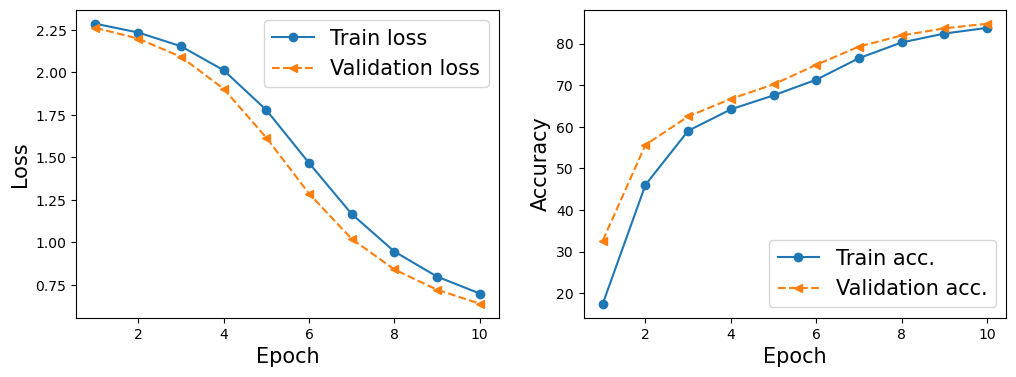

In [42]:
plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])
plt.show()

**Interpretation** Looking at the curves, it seems like we could do with some more training, since the loss is still steadily going down and the accuracy is still going up.

--------------




## Saving & Loading Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [43]:
torch.save(model.state_dict(), "models/qs_model.pth")
print("Saved PyTorch Model State to models/qs_model.pth")

Saved PyTorch Model State to models/qs_model.pth


The process for loading a model includes re-creating the model structure and loading
the state dictionary into it. When doing so, be sure to move the model to the right *device* again.

In [44]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("models/qs_model.pth"))

<All keys matched successfully>

Read more about [Saving & Loading your model](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html).

---

## Applying the model aka Inference
The ultimate goal, obviously, is to use a model on unseen data. This application of the model is usually called *inference* and takes much less time than training. Let's see how our model does on specific instances or specific batches of our (test) data.

In [45]:
# our classes are just the numbers from 0 to 9
classes = range(10)

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad(): # no info for backward pass needed
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


We can also test an individual batch and even visualize the predictions along with the actual images and the corresponding *ground truth*.

In [46]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

In [47]:
batch_test = next(iter(test_dataloader))

preds, _ = predict_batch(model, batch_test[0][:12], binary=False)

print(preds)

tensor([7, 2, 1, 0, 4, 1, 9, 9, 6, 9, 0, 6])


### Visual quality control

In order to get a better feeling for the model quality, it often makes sense to look at the actual data and compare the predictions to the ground truth at least for some examples.

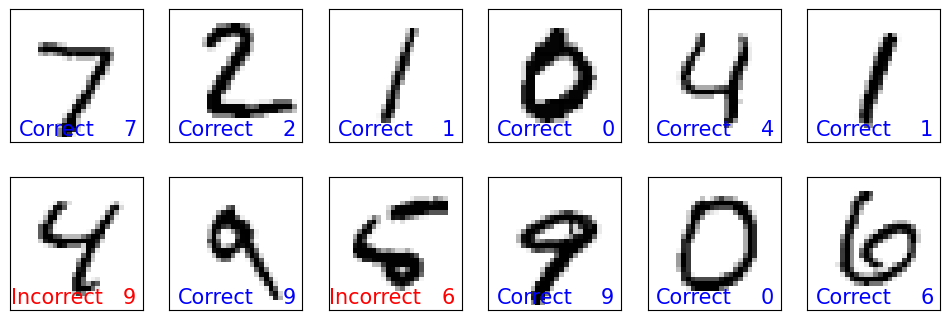

In [48]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(12, 4))
    for i in range(12):
        correct = preds[i] == batch_test[1][i]
        ax = fig.add_subplot(2, 6, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, '{}'.format(preds[i]), 
                size=15, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.35, 0.1, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=15, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

Obviously, one of the misclassifications we see here (bottom left) is hard to understand, while for the third one in the bottom row is a little hard to see even for a human whether the ground truth might say $5$ here ...

---

## Learning Outcomes

The contents presented here were mostly geared towards getting into touch with `PyTorch`. Having worked through this notebook, you should now

* be aware that `PyTorch` comes with datasets to be used directly and experiment with;
* know that `PyTorch` can make use of powerful hardware like GPUs for acceleration;
* have a feeling for the way neural networks may be specified and used in `PyTorch`;
* know how to train a model and use it for inference in `PyTorch`.

---